First of all the standard packages will be installed and we check which version of the CLMM code is currently installed

In [1]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import units
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm import support
from clmm.support import mock_data as mock
from clmm.support import sampler
from clmm.support.sampler import *
from clmm.support.sampler import fitters
import random
from scipy.interpolate import interp1d

plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

clmm.__version__


/Users/nicomasii/opt/anaconda3/lib/python3.8/site-packages/clmm-1.0.5-py3.8.egg/clmm/theory/__init__.py:38: UserWarning: CLMM Backend requested `ccl' is not available, trying others...
/Users/nicomasii/opt/anaconda3/lib/python3.8/site-packages/clmm-1.0.5-py3.8.egg/clmm/theory/__init__.py:48: UserWarning: * NumCosmo BACKEND also not available
/Users/nicomasii/opt/anaconda3/lib/python3.8/site-packages/clmm-1.0.5-py3.8.egg/clmm/theory/__init__.py:45: UserWarning: * USING cluster_toolkit+astropy BACKEND


'1.0.5'

Since we are working with the random modul we use random seed in the next step for reproducibility.


In [2]:
np.random.seed(22)

To create mock data, we need to define a true cosmology, which is currently done with astropy's cosmology library.

In [3]:
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)


We now set some parameters for a mock galaxy cluster:
    cluster_data[k][0] = cluster_m
    cluster_data[k][1] = concentration
    cluster_data[k][2] = cluster_ra
    cluster_data[k][3] = cluster_dec
    cluster_data[k][4] = cluster_z
    cluster_data[k][5] = ngals
    cluster_data[k][6] = logm
    cluster_data[k][7] = number density 
and print the array

[1.22302896e+13 1.74080089e+13 1.58868846e+13 ... 1.06047787e+13
 3.68544956e+13 1.31480425e+13]


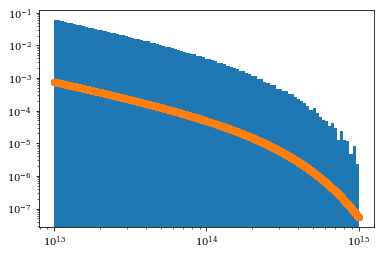

In [4]:
lower_limit =13
upper_limit =15
nbinhist=100
norm = (upper_limit-lower_limit)/nbinhist

M_star = 2.e14
b=4*10**(-5)
numsamp= 10**6
numstep = 10**4

#define x range 1e12-1e15 in num steps
x = np.logspace(lower_limit,upper_limit,numstep)
#define y values from the function 
y = (b*(1/(x/M_star))*np.exp(-(x)/M_star))

#calculate cumulative sum of the y values (numpy)
y_cm = np.cumsum(y)
y_cm = y_cm-min(y_cm)
y_cm = y_cm/np.max(y_cm)

#invert x and y variables (flipping)and interpolate that function 
f = interp1d(y_cm,x , fill_value=(0,1))
#Generate N random numbers uniformly between 0 & 1: u_i~U(0,1)
ynew = np.random.random(numsamp)
#Using the Inverse of the CDF and the values u_i, compute x_i = F^-1(u_i)
x_samp = f(ynew) 

#plot it to see the result
plt.hist(x_samp, bins=np.logspace(lower_limit,upper_limit,nbinhist),weights=np.repeat(numsamp/sum(y*x),numsamp)/norm)
plt.yscale('log')
plt.xscale('log')
plt.plot(x, y, 'o')
#plt.show()

print(x_samp)

#use that interpolated function to predict num samples



In [5]:
np.set_printoptions(precision=3)   
num = 200
cluster_data = np.zeros((num,7))
#m_star=1.8.e14
for k in range(num):
   #cluster_data[k][7] = np.random.randint(1.e(-8),1.e(-2))    
    cluster_data[k][0] = x_samp[k] #masse
    cluster_data[k][6] = np.log(cluster_data[k][0])/np.log(10)#logm
    cluster_data[k][2] = 0#ra
    cluster_data[k][3] = 0#dec
    cluster_data[k][4] = np.random.uniform(0.1,0.6)#redshift
    cluster_data[k][1] = 5.72/((1+cluster_data[k][4])**0.71)*(cluster_data[k][0]/10.e14)**(-0.081)#consentration
    cluster_data[k][5] = np.random.randint(50,10000)#ngals
    print(cluster_data[k][0])
    
     
#print(cluster_data)
print(cluster_data[k][0])

12230289609061.307
17408008914007.672
15886884555037.807
46170951813744.2
11758807418077.158
14238157179358.623
13107865305848.945
26194078723807.25
12389621903030.055
37772241090163.73
10092478469569.16
19912330523886.066
38027376945554.23
30279651543333.14
11980942507370.023
10053735654418.32
32879604863906.676
96440922686976.36
26920471955262.855
13532336030506.545
32458195314729.72
26012643984144.805
15167843823832.652
22096668866748.75
16047285650211.96
20788108179520.23
26968446097937.992
11081943738901.477
68260156916290.914
182980801179787.2
25342077094814.242
35532348744552.5
10259777415567.924
11839461663270.957
49996702831270.28
30264804591649.1
18163526025458.305
11261528077696.365
17479556366198.572
18396393543687.406
13758166089151.057
10414253127006.408
16284767784671.797
10912604340536.41
10409985448914.92
25798298821855.656
44062625749020.984
11226911279144.9
11269643531541.057
17175363281038.676
12088498556295.025
33924851714713.95
21750739664601.574
16424598561161.68

In [6]:
'''
import numpy as np
import scipy.interpolate as interpolate

def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)
'''

'\nimport numpy as np\nimport scipy.interpolate as interpolate\n\ndef inverse_transform_sampling(data, n_bins=40, n_samples=1000):\n    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)\n    cum_values = np.zeros(bin_edges.shape)\n    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))\n    inv_cdf = interpolate.interp1d(cum_values, bin_edges)\n    r = np.random.rand(n_samples)\n    return inv_cdf(r)\n'

In [7]:
'''
#input mass
#print(cluster_data[:,0])
plt.hist(cluster_data[:,0], 50, density=1, facecolor='g', alpha=0.75)
#plt.plot(cluster_data[:,0] ,  , "ob")
plt.xlabel('M_input')
plt.ylabel('N')
plt.show()
'''

'\n#input mass\n#print(cluster_data[:,0])\nplt.hist(cluster_data[:,0], 50, density=1, facecolor=\'g\', alpha=0.75)\n#plt.plot(cluster_data[:,0] ,  , "ob")\nplt.xlabel(\'M_input\')\nplt.ylabel(\'N\')\nplt.show()\n'

In [8]:

ideal_data = []
noisy_data = []

for k in range(num):
    buggy_data = mock.generate_galaxy_catalog(cluster_data[k][0], 
                                              cluster_data[k][4], 
                                              cluster_data[k][1], 
                                                           cosmo, 
                                                       'chang13', 
                             zsrc_min = cluster_data[k][4] + 0.1,
                                                 shapenoise=0.05, 
                                      photoz_sigma_unscaled=0.05, 
                                    ngals=int(cluster_data[k][5])) 
    
    #sortiert nachher die galaxien raus die den falschen redshift besitzen
    mask = buggy_data['z'] < cluster_data[k][4] 
    #die galaxien sollten entfernt werden nicht maskiert...nur vorrübergehend
   
    buggy_data['z'] = np.where(buggy_data['z'] < cluster_data[k][4], 
                               np.random.uniform(cluster_data[k][4],
                                            cluster_data[k][4]+0.1), 
                                                    buggy_data['z'])
    
    mask = buggy_data['z'] < cluster_data[k][4]
    realredshift = buggy_data['z']
    #print(sum(buggy_data['z']<=cluster_data[k][4]))

    ideal_data.append(mock.generate_galaxy_catalog(cluster_data[k][0],
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1],
                                                                cosmo,
                                                            'chang13',
                                  zsrc_min = cluster_data[k][4] + 0.1, 
                                     ngals = int(cluster_data[k][5]))) 
    noisy_data.append(buggy_data)


    

Now we plot the redshifts to see of we have any redshifts under the cluster redshift

In [9]:
'''
for k in range(num):
    plt.figure(figsize=(7,5))
    plt.hist(ideal_data[k]['z'], density = True, alpha=0.5, bins = 50, label='ideal data')
    plt.hist(noisy_data[k]['z'], alpha=0.5, density = True, bins = 50, label='noisy data')
    plt.axvline(x = cluster_data[k][4], color='orange', label = 'cluster redshift')
    plt.xlabel(r'$z_{src}$', fontsize = 20)
    plt.ylabel(r'$N(z$)', fontsize = 20)
    plt.legend()
    plt.xlim(0,5)
    plt.show()
'''

"\nfor k in range(num):\n    plt.figure(figsize=(7,5))\n    plt.hist(ideal_data[k]['z'], density = True, alpha=0.5, bins = 50, label='ideal data')\n    plt.hist(noisy_data[k]['z'], alpha=0.5, density = True, bins = 50, label='noisy data')\n    plt.axvline(x = cluster_data[k][4], color='orange', label = 'cluster redshift')\n    plt.xlabel(r'$z_{src}$', fontsize = 20)\n    plt.ylabel(r'$N(z$)', fontsize = 20)\n    plt.legend()\n    plt.xlim(0,5)\n    plt.show()\n"

Now we compete the radius which we will need later on

In [10]:
radius = []
for k in range(num):
    variable = clmm.dataops._compute_lensing_angles_astropy(cluster_data[k][2], 
                                                            cluster_data[k][3], 
                                                            ideal_data[k]['ra'], 
                                                            ideal_data[k]['dec'])
    radius.append(variable)

The galaxy catalogs are converted to a clmm.GalaxyCluster object and may be saved for later use.


In [11]:
gc_object =[]

for k in range(num):

    cluster_id = "CL_ideal"
    gc_object.append( clmm.GalaxyCluster(cluster_id, 
                                 cluster_data[k][2],
                                 cluster_data[k][3],
                                 cluster_data[k][4], 
                                     ideal_data[k]))
    gc_object[k].save('ideal_GC_'+str(k)+'.pkl')

gc_object =[]

for k in range(num):

    cluster_id = "CL_noisy"
    gc_object.append( clmm.GalaxyCluster(cluster_id,
                                 cluster_data[k][2],
                                 cluster_data[k][3],
                                 cluster_data[k][4], 
                                     noisy_data[k]))
    gc_object[k].save('noisy_GC_'+str(k)+'.pkl')


Any saved clmm.GalaxyCluster object may be read in for analysis.

In [12]:
cl_ideal = []
cl_noisy = []
for k in range(num):
    cl_ideal.append (clmm.GalaxyCluster.load('ideal_GC_'+str(k)+'.pkl'))
    cl_noisy.append (clmm.GalaxyCluster.load('noisy_GC_'+str(k)+'.pkl'))

Redshift of galaxies generated by mock data are distributed following the Chang. (2013) redshift distribution.

In [13]:
'''
for k in range(num):
    plt.figure(figsize=(7,5))
    plt.hist(cl_ideal[k].galcat['z'], density = True, bins = 50)
    plt.axvline(x = cluster_data[k][4], color='orange', label = 'cluster redshift')
    plt.xlabel(r'$z_{src}$', fontsize = 20)
    plt.ylabel(r'$N(z$)', fontsize = 20)
    plt.legend()
    plt.xlim(0,5)
'''

"\nfor k in range(num):\n    plt.figure(figsize=(7,5))\n    plt.hist(cl_ideal[k].galcat['z'], density = True, bins = 50)\n    plt.axvline(x = cluster_data[k][4], color='orange', label = 'cluster redshift')\n    plt.xlabel(r'$z_{src}$', fontsize = 20)\n    plt.ylabel(r'$N(z$)', fontsize = 20)\n    plt.legend()\n    plt.xlim(0,5)\n"

Deriving observables

Computing shear

clmm.GalaxyCluster.compute_tangential_and_cross_components calculates the tangential and cross shears for each source galaxy in the cluster.

In [14]:
for k in range(num):
    cl_ideal[k].compute_tangential_and_cross_components(geometry="flat")
    cl_noisy[k].compute_tangential_and_cross_components(geometry="flat")
pass

Radially binning the data

In [15]:
bin_edges = da.make_bins(0.2, 4, 15, method='evenwidth')

In [16]:
for k in range(num):

    a = cl_ideal[k].make_radial_profile("Mpc",
                      include_empty_bins=True, 
                               bins=bin_edges, 
                                  cosmo=cosmo, 
                         gal_ids_in_bins=True,)#return_binnumber=True does not work
    
    b = cl_noisy[k].make_radial_profile("Mpc",
                      include_empty_bins=True, 
                               bins=bin_edges,
                                  cosmo=cosmo, 
                         gal_ids_in_bins=True,)
    #masking
    maski = cl_ideal[k].profile['z'] > cluster_data[k][4]
    maskn = cl_noisy[k].profile['z'] > cluster_data[k][4]
    mask= maski*maskn
    cl_ideal[k].profile =  cl_ideal[k].profile[mask]
    cl_noisy[k].profile =  cl_noisy[k].profile[mask]
    print(k)
    print(cl_ideal[k].profile['gt_err'])

pass


0
        gt_err        
----------------------
0.00017284928105919757
 5.398208709385795e-05
2.1125694913299954e-05
 1.163223074040424e-05
 8.318131599305584e-06
 4.953558689360182e-06
 3.912859136010497e-06
2.6525699728277707e-06
 2.056491279907563e-06
1.7435934999165934e-06
1.3978914790827628e-06
1.1993385920531353e-06
 9.946344663095283e-07
  8.17261680140368e-07
 7.194752518024332e-07
1
        gt_err        
----------------------
 0.0004057638875086004
 0.0001225610709981856
5.4789728762199424e-05
2.8446761887618294e-05
 2.047349758491419e-05
1.3875471875138138e-05
 1.012092780648204e-05
 7.360714662583173e-06
 5.965204279029738e-06
4.8126312464517374e-06
 4.036518564984996e-06
3.3091047746487637e-06
 2.942421988741834e-06
 2.470940488932365e-06
 2.136178765633266e-06
2
        gt_err        
----------------------
 0.0003574537296092736
 0.0001600891225034398
 6.825036842187721e-05
  3.18673862225493e-05
2.0857487514740004e-05
 1.696798746558595e-05
1.2843070428969166e-05
 9.47

21
        gt_err        
----------------------
0.00040121761169055107
 0.0001137241324168048
 6.196902680239926e-05
 3.437186862226007e-05
2.1350842296404825e-05
1.4976869258835348e-05
1.1057398032933955e-05
 8.577806135682334e-06
  7.30675688081572e-06
  5.66666660065885e-06
 4.536927372190112e-06
3.8621440477093215e-06
 3.278016910651522e-06
2.6382579236970384e-06
 2.354716929008435e-06
22
        gt_err        
----------------------
 0.0006111851095334809
 0.0002513623494960374
 0.0001208549883766585
 6.469185422760324e-05
4.3045303584958535e-05
 3.000769484323963e-05
 2.077824857421005e-05
 1.679677135172182e-05
1.2178625418193428e-05
1.0791433654126369e-05
  8.45887223763834e-06
 6.508919579855411e-06
 6.006033448779682e-06
5.3579905715561855e-06
 4.719318213781034e-06
23
        gt_err        
----------------------
 0.0008071021832353243
0.00028647589810112934
 0.0001552003159650342
 9.367156215305495e-05
  5.31182362517924e-05
 3.884924109421698e-05
2.8439923727786878e-05
 2

45
        gt_err        
----------------------
 0.0007056311226495999
0.00023492910471148586
0.00012252231911346852
 8.498122488094213e-05
  4.56867983802075e-05
3.4746153923202345e-05
2.3299321520738963e-05
1.8410554628110696e-05
1.3759563114696196e-05
1.2020272841468136e-05
1.0125711501326372e-05
 8.470550778347218e-06
 6.691810243250198e-06
  5.82973836611931e-06
 5.704553576260014e-06
46
        gt_err        
----------------------
 0.0008407895249538786
  0.000297798163533285
0.00016741079038144155
 9.942299187443171e-05
 6.305006481536818e-05
 4.687443506910173e-05
3.5322399541122434e-05
2.7662613595285334e-05
2.1363933858588205e-05
1.7084719572387472e-05
1.4582573993806445e-05
1.2532547594232645e-05
1.0292528468823795e-05
 8.848609718440044e-06
 7.708486994216076e-06
47
        gt_err        
----------------------
 0.0001339933011695828
 3.379808706350447e-05
 1.641781244009796e-05
 8.097335374194418e-06
 5.130587990742206e-06
 3.863649137405514e-06
 2.731670935244306e-06
1.

69
        gt_err        
----------------------
0.00012922581190201658
 3.200246339352712e-05
1.5646919679488583e-05
 9.714086625898412e-06
 4.816105616899928e-06
3.2307949130610356e-06
 2.507250136778713e-06
1.6976227453807895e-06
1.3827839373096066e-06
1.1521861348267415e-06
 9.467577461899639e-07
 7.575386326309148e-07
 6.322953442116834e-07
  5.25550909306131e-07
4.6081363463625685e-07
70
        gt_err        
----------------------
 0.0003386262312861465
 8.300496059675984e-05
 4.776035354462812e-05
2.7420978881511993e-05
1.7800052626473694e-05
1.1857429638595868e-05
 7.861303018979849e-06
  6.31631732577442e-06
 5.261900541095326e-06
 4.062020855553372e-06
3.2585426625196113e-06
2.8158912926364358e-06
2.4797014382096124e-06
 2.032778503266383e-06
 1.752002841699317e-06
71
        gt_err        
----------------------
 0.0008338355166364087
0.00031237462797791275
0.00016891473403791667
 0.0001276438578500104
 8.616300380490071e-05
 5.381190981919855e-05
 3.098193393263196e-05
2.

94
        gt_err        
----------------------
 0.0004349272785722547
0.00012007024885434988
   6.2444355437276e-05
 4.055609624208463e-05
 2.605114890873338e-05
1.7461343627283615e-05
1.1510302780300925e-05
1.0375503539582792e-05
 7.836267183304978e-06
5.9223189193651895e-06
 4.851329343387216e-06
   4.1320388082892e-06
 3.727694834888284e-06
3.0176430513100603e-06
 2.454863304582075e-06
95
        gt_err        
----------------------
0.00020544353056966335
0.00037293206799287476
 0.0001640572354592977
0.00011806329469739134
 6.729020581382764e-05
5.5640703277531855e-05
 3.457939230546181e-05
2.9223500552375757e-05
2.6432054972961303e-05
 1.911212719932601e-05
 1.393251563469333e-05
1.2660634452227094e-05
1.0163086897963921e-05
 8.772595536493362e-06
 8.463363681646107e-06
96
        gt_err        
----------------------
 0.0007971494092054691
 0.0002647300578670395
 0.0001331027417718119
 7.022629833445645e-05
 5.602460381698619e-05
 3.463956447214888e-05
2.6687771417181293e-05
2.

115
        gt_err        
----------------------
0.00026078756799534055
0.00010225240254908935
 4.969682300088229e-05
2.5967488309536687e-05
1.7751607783940313e-05
1.1355684210552812e-05
 9.226088449627577e-06
 6.949437083428217e-06
 5.361541065336259e-06
 4.581133730934797e-06
3.6962723251786278e-06
  2.97064449308663e-06
2.4868941936786414e-06
2.2238369244231623e-06
 1.822704106340679e-06
116
        gt_err        
----------------------
 0.0006660771001392029
 0.0002068423597610218
0.00011219227868831133
 7.075684084494413e-05
4.4681797031661354e-05
 2.883072786874948e-05
 2.313064454106831e-05
1.8615827733056732e-05
 1.359096773422634e-05
1.2804614068044612e-05
 9.075402164465057e-06
 7.752409685651805e-06
 6.293714895113952e-06
 5.500742285139838e-06
 4.901078620022397e-06
117
        gt_err        
----------------------
 0.0009119143324173716
 0.0002434741516462888
0.00015089751878961428
   7.4695687058072e-05
5.5463974828712646e-05
3.7926393100515974e-05
 2.692430993327716e-05

141
        gt_err        
----------------------
 0.0005425337484852109
0.00016708064858674261
 7.756789985232842e-05
 4.401751100854172e-05
 3.038692722180048e-05
2.1878773419201865e-05
1.5792693382555088e-05
1.1395476871170282e-05
 8.179043881437105e-06
 6.919752866320744e-06
5.9888962478292436e-06
 5.012227370021429e-06
 4.081509262504437e-06
3.5222381327947966e-06
3.0820750444537066e-06
142
        gt_err        
----------------------
  0.000993255192110296
0.00032122485353547575
0.00014676865062218918
0.00010201544058290126
 6.820820941049886e-05
 4.670467827701304e-05
3.5943478027250174e-05
 2.788263782663184e-05
 2.363086059541117e-05
1.7177792391449458e-05
1.5000677979006422e-05
1.2611276331510049e-05
1.1245511966139999e-05
 9.150290370859599e-06
7.4815623707028325e-06
143
        gt_err        
----------------------
0.00024657201994142305
 4.995153466537182e-05
2.6366639454163653e-05
1.5173803342624817e-05
 8.370327038832541e-06
 6.523598020953611e-06
5.1620519065470985e-06

163
        gt_err        
----------------------
 0.0001667407392551927
5.7794264786129555e-05
 2.602605864231931e-05
1.2544122310045313e-05
 8.643318382144078e-06
 6.032792497739865e-06
 4.095841979519669e-06
  3.55512979354704e-06
 2.620918172023013e-06
2.1262337434528414e-06
1.7181275416764587e-06
1.3524834555479007e-06
1.2503600021132905e-06
1.0452020611208218e-06
  8.46280537994327e-07
164
        gt_err        
----------------------
 0.0008364010002988419
0.00020371413854516538
0.00012762614806627033
 6.102734477237694e-05
 5.927764151159396e-05
  3.54140120965691e-05
 2.290924237182346e-05
 1.946129742972333e-05
 1.412610135456212e-05
 1.078248413620306e-05
 9.605295414731557e-06
1.0521979396943525e-05
 7.887352550726665e-06
7.0364367153143945e-06
 6.011992842857415e-06
165
        gt_err        
----------------------
  0.001666373867513988
 0.0006527507277815371
 0.0006258328326807568
 0.0004891929587001151
0.00026322918133194173
 0.0001392090489223134
0.00013085953647925375

186
        gt_err        
----------------------
0.00030723756011518175
  9.57348208263182e-05
 4.622831716987232e-05
2.4956436277438932e-05
1.7752821202019894e-05
1.2452153514118156e-05
 8.880883045614237e-06
 6.647651311370252e-06
 5.557040870489507e-06
 4.093314095761713e-06
3.5295985766373126e-06
2.9649754689187537e-06
2.4249174062690982e-06
 2.080157728523781e-06
1.7879541033395055e-06
187
        gt_err        
----------------------
 0.0009530662407451094
  0.000296483905322586
 0.0001424673524873995
 9.847265497754148e-05
6.0181935332905005e-05
4.3715293829181124e-05
 3.282660225148696e-05
2.5952315415200978e-05
 2.079627004006401e-05
1.6268587779952803e-05
 1.374285178656065e-05
1.0872248011314683e-05
 9.698205500961557e-06
 8.257432480097628e-06
  7.39132513214712e-06
188
        gt_err        
----------------------
  0.000474801378232786
0.00015691849001403397
 6.664804535238251e-05
 4.635316385792065e-05
2.8023605396571997e-05
 1.940286749906331e-05
1.4292069563977447e-05

After this, the object acquires the clmm.GalaxyCluster.profile attribute.

#Create the reduced tangential shear models
We consider two options:

First, the naive and wrong approach: the reduced tangential shear in a given radial bin 𝑗 is given by 𝑔𝑡(𝜃𝑗,⟨𝑧𝑠⟩), where ⟨𝑧𝑠⟩ is the average redshift in the bin. In that case, the corresponding model is simply given by the fucntion below:


In [17]:
def model_reduced_tangential_shear_zdistrib(radius, 
                                              logm,
                                              data,
                                           catalog,
                                           profile, 
                                         cluster_z,
                                    concentration): 
    m = 10**logm
    gt_model = []
    for i in range(len(radius)):
        
        r = profile['radius'][i]
        galist = profile['gal_id'][i]
        
        z_list = catalog.galcat['z'][galist]
        shear = clmm.compute_reduced_tangential_shear(r,
                                                      m,
                                          concentration,
                                              cluster_z,
                                                 z_list, 
                                                  cosmo, 
                                         delta_mdef=200, 
                               halo_profile_model='nfw')
        if len(galist) == 0:
            gt_model.append(1e-16)
            print("this is bad")
        else:
            gt_model.append(np.mean(shear))

    return gt_model

In [18]:
def model_reduced_tangential_shear_singlez(r,
                                        logm,
                                       z_src,
                                   cluster_z,
                              concentration):
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m,
                                         concentration,
                                             cluster_z,
                                                 z_src,
                                                 cosmo,
                                        delta_mdef=200,
                              halo_profile_model='nfw')    
    return gt_model

Before fitting, let's first vizualise these models using the known true mass

In [19]:
gt_model_ideal_singlez = []
gt_model_ideal_zdistrib = []
gt_model_noisy_singlez = []
gt_model_noisy_zdistrib = []
r=[]
for k in range(num):
    r.append(cl_ideal[k].profile['radius'])

    gt_model_ideal_singlez.append(model_reduced_tangential_shear_singlez(r[k], 
                                                           cluster_data[k][6],
                                                     cl_ideal[k].profile['z'],
                                                           cluster_data[k][4], 
                                                          cluster_data[k][1]))
    
    gt_model_ideal_zdistrib.append(model_reduced_tangential_shear_zdistrib(r[k],
                                                             cluster_data[k][6],
                                                                  ideal_data[k],
                                                                    cl_ideal[k], 
                                                            cl_ideal[k].profile,
                                                             cluster_data[k][4], 
                                                            cluster_data[k][1]))
    
    gt_model_noisy_singlez.append(model_reduced_tangential_shear_singlez(r[k],
                                                           cluster_data[k][6],
                                                     cl_noisy[k].profile['z'],
                                                           cluster_data[k][4], 
                                                          cluster_data[k][1]))
    
    gt_model_noisy_zdistrib.append(model_reduced_tangential_shear_zdistrib(r[k],
                                                             cluster_data[k][6],
                                                                  noisy_data[k], 
                                                                    cl_noisy[k], 
                                                            cl_noisy[k].profile,
                                                             cluster_data[k][4], 
                                                            cluster_data[k][1]))


In [20]:
'''
for k in range (num):
    print(k)
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)

    plt.title('ideal data', fontsize=20)
    plt.errorbar(r[k],
                 cl_ideal[k].profile['gt'],
                 cl_ideal[k].profile['gt_err'],
                 c='k',linestyle='', 
                 marker='o',
                 label=r'ideal data, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_model_ideal_zdistrib[k],'b', 
               label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_model_ideal_singlez[k],'-y', 
               label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_ideal[k].profile['radius']), max(cl_ideal[k].profile['radius']))
    plt.legend(fontsize = 15)

    plt.subplot(1,2,2)

    plt.title('noisy data', fontsize=20)
    plt.errorbar(r[k],
                 cl_noisy[k].profile['gt'],
                 cl_noisy[k].profile['gt_err'],
                 c='k',
                 linestyle='', 
                 marker='o',
                 label=r'noisy data, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],
               gt_model_noisy_zdistrib[k],
               '-b', 
               label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.loglog(r[k],
               gt_model_noisy_singlez[k],
               '-y',
               label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])
    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_noisy[k].profile['radius']), max(cl_noisy[k].profile['radius']))
    plt.ylim(min(gt_model_ideal_zdistrib[k]),max(gt_model_ideal_zdistrib[k]))
    plt.legend(fontsize = 15)
'''

"\nfor k in range (num):\n    print(k)\n    plt.figure(figsize=(20,8))\n\n    plt.subplot(1,2,1)\n\n    plt.title('ideal data', fontsize=20)\n    plt.errorbar(r[k],\n                 cl_ideal[k].profile['gt'],\n                 cl_ideal[k].profile['gt_err'],\n                 c='k',linestyle='', \n                 marker='o',\n                 label=r'ideal data, $M_{input}$ = %.2e Msun' % cluster_data[k][0])\n    plt.loglog(r[k],gt_model_ideal_zdistrib[k],'b', \n               label=r'model w/ zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])\n    plt.loglog(r[k],gt_model_ideal_singlez[k],'-y', \n               label=r'model w/o zdistrib, $M_{input}$ = %.2e Msun' % cluster_data[k][0])\n    plt.xlabel('r [Mpc]', fontsize = 20)\n    plt.ylabel(r'$g_t$', fontsize = 20)\n    plt.xlim(min(cl_ideal[k].profile['radius']), max(cl_ideal[k].profile['radius']))\n    plt.legend(fontsize = 15)\n\n    plt.subplot(1,2,2)\n\n    plt.title('noisy data', fontsize=20)\n    plt.errorbar(r[k],\n   

The naive model that uses the average redshift in the bin clearly does not give the right description of the ideal data (left panel), and will yield biased mass results if used for fitting (see below). For ideal data, the model that accounts for the redshift distribution is, by construction, an excellent description of the data (solid blue line). The same is true for noisy data (right panel), although the noise make the naive model appear "less biased".


Mass fitting
We estimate the best-fit mass using scipy.optimize.curve_fit. We compare estimated mass for noisy and ideal data, using both models described above (naive with average redshift or the model taking into account the redshift distribution). The choice of fitting log10𝑀 instead of 𝑀 lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error Δ(log10𝑀) we calculate the error to mass as Δ𝑀=𝑀𝑓𝑖𝑡log(10)Δ(log10𝑀).

In [21]:
for k in range(num):
    print(k)
    for l in range(np.size(cl_ideal[k].profile)):
        if cl_ideal[k].profile['gt_err'][l] == 0:
            cl_ideal[k].profile['gt_err'][l] = 0.0001
            #das sollte ich definitiv noch ändern geschummelt ich haben

        print(cl_ideal[k].profile['gt_err'][l])

0
0.00017284928105919757
5.398208709385795e-05
2.1125694913299954e-05
1.163223074040424e-05
8.318131599305584e-06
4.953558689360182e-06
3.912859136010497e-06
2.6525699728277707e-06
2.056491279907563e-06
1.7435934999165934e-06
1.3978914790827628e-06
1.1993385920531353e-06
9.946344663095283e-07
8.17261680140368e-07
7.194752518024332e-07
1
0.0004057638875086004
0.0001225610709981856
5.4789728762199424e-05
2.8446761887618294e-05
2.047349758491419e-05
1.3875471875138138e-05
1.012092780648204e-05
7.360714662583173e-06
5.965204279029738e-06
4.8126312464517374e-06
4.036518564984996e-06
3.3091047746487637e-06
2.942421988741834e-06
2.470940488932365e-06
2.136178765633266e-06
2
0.0003574537296092736
0.0001600891225034398
6.825036842187721e-05
3.18673862225493e-05
2.0857487514740004e-05
1.696798746558595e-05
1.2843070428969166e-05
9.474694529896286e-06
7.701046532285547e-06
6.254642164329589e-06
4.986126087133195e-06
4.346862783524254e-06
3.4124330215488057e-06
3.0497738065572647e-06
2.53730529901

3.3978187677160046e-05
2.4007304895797292e-05
1.7764214798677842e-05
1.3039739715249625e-05
1.0121201643390238e-05
9.12139425995663e-06
6.96914148084956e-06
5.9273758651739156e-06
5.085944147803109e-06
4.389179722164677e-06
3.7066493527379056e-06
110
0.0002335410509939315
5.826567462867461e-05
2.5019152078065366e-05
1.6174765244535566e-05
8.609083235732763e-06
6.197530097472565e-06
4.455012762015512e-06
3.517938297870518e-06
2.533603758047721e-06
2.067585158496985e-06
1.670580083560438e-06
1.368894451809499e-06
1.2734151655847609e-06
9.999502446939257e-07
8.349580662615951e-07
111
0.000183687852925968
5.503043337473948e-05
2.4526101819176363e-05
1.3855103827905419e-05
9.069801617832454e-06
6.10943227388709e-06
4.778766789372924e-06
3.4737678264600927e-06
2.594896559939403e-06
2.1358859046559244e-06
1.6817714920385382e-06
1.5470029818177191e-06
1.3261213036801062e-06
1.1139222782244571e-06
8.909538781827204e-07
112
0.0002506806695878414
0.00010602101603717477
4.621236018052069e-05
2.446

In [22]:
m_est_ideal_zdistrib = [None]*num
m_est_err_ideal_zdistrib = [None]*num
for k in range(num):

    func = lambda r, x : model_reduced_tangential_shear_zdistrib(r,x, 
                                                       ideal_data[k],
                                                         cl_ideal[k], 
                                                 cl_ideal[k].profile, 
                                                  cluster_data[k][4], 
                                                  cluster_data[k][1])

    popt,pcov = fitters['curve_fit'](func, 
                        cl_ideal[k].profile['radius'], 
                        cl_ideal[k].profile['gt'], 
                        cl_ideal[k].profile['gt_err'], bounds=[10.,17.])#p0 war bei 14.6 habe ich gelöscht

    
    m_est_ideal_zdistrib[k] = 10.**popt[0]
    m_est_err_ideal_zdistrib[k] =  m_est_ideal_zdistrib[k] * np.sqrt(pcov[0][0]) * np.log(10) 
   
        


In [23]:
m_est_ideal_singlez = [None]*num
m_est_err_ideal_singlez = [None]*num
for k in range(num):

    funct = lambda r, logm : model_reduced_tangential_shear_singlez(r,
                                                                 logm, 
                                             cl_ideal[k].profile['z'], 
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_ideal[k].profile['radius'], 
                        cl_ideal[k].profile['gt'], 
                        cl_ideal[k].profile['gt_err'], bounds=[10.,17.])

    m_est_ideal_singlez[k] = 10.**popt[0]
    m_est_err_ideal_singlez[k] = m_est_ideal_singlez[k] * np.sqrt(pcov[0][0]) * np.log(10)



In [24]:
for k in range(num):
    print(k)
    for l in range(np.size(cl_ideal[k].profile)):
        if cl_noisy[k].profile['gt_err'][l] == 0:
            cl_noisy[k].profile['gt_err'][l] = 0.0022713490203193337
            #das sollte ich definitiv noch ändern geschummelt ich haben

        print(cl_ideal[k].profile['gt_err'][l])

0
0.00017284928105919757
5.398208709385795e-05
2.1125694913299954e-05
1.163223074040424e-05
8.318131599305584e-06
4.953558689360182e-06
3.912859136010497e-06
2.6525699728277707e-06
2.056491279907563e-06
1.7435934999165934e-06
1.3978914790827628e-06
1.1993385920531353e-06
9.946344663095283e-07
8.17261680140368e-07
7.194752518024332e-07
1
0.0004057638875086004
0.0001225610709981856
5.4789728762199424e-05
2.8446761887618294e-05
2.047349758491419e-05
1.3875471875138138e-05
1.012092780648204e-05
7.360714662583173e-06
5.965204279029738e-06
4.8126312464517374e-06
4.036518564984996e-06
3.3091047746487637e-06
2.942421988741834e-06
2.470940488932365e-06
2.136178765633266e-06
2
0.0003574537296092736
0.0001600891225034398
6.825036842187721e-05
3.18673862225493e-05
2.0857487514740004e-05
1.696798746558595e-05
1.2843070428969166e-05
9.474694529896286e-06
7.701046532285547e-06
6.254642164329589e-06
4.986126087133195e-06
4.346862783524254e-06
3.4124330215488057e-06
3.0497738065572647e-06
2.53730529901

2.2381838959760473e-05
2.082030086159119e-05
1.7793769342882146e-05
1.478842178287796e-05
1.1881154600634524e-05
9.612427953390385e-06
114
0.0008189960254486912
0.0002519028167534588
0.00010846617876294129
6.179778602341501e-05
4.120206785027548e-05
3.8595729593136075e-05
2.551017350456617e-05
1.7966986928583017e-05
1.4235379626434804e-05
1.042042609862469e-05
9.501791121481275e-06
8.75240259017921e-06
6.315524319209061e-06
6.001729188251165e-06
4.443573936159299e-06
115
0.00026078756799534055
0.00010225240254908935
4.969682300088229e-05
2.5967488309536687e-05
1.7751607783940313e-05
1.1355684210552812e-05
9.226088449627577e-06
6.949437083428217e-06
5.361541065336259e-06
4.581133730934797e-06
3.6962723251786278e-06
2.97064449308663e-06
2.4868941936786414e-06
2.2238369244231623e-06
1.822704106340679e-06
116
0.0006660771001392029
0.0002068423597610218
0.00011219227868831133
7.075684084494413e-05
4.4681797031661354e-05
2.883072786874948e-05
2.313064454106831e-05
1.8615827733056732e-05
1.35

3.884833030024765e-06
3.3075451360851534e-06
190
0.0004359097521051247
0.00012932757332513204
5.910753507458355e-05
3.34737354527004e-05
2.3756956603076416e-05
1.5163304479805591e-05
1.0875962695829157e-05
9.171226439164754e-06
6.91560938737597e-06
5.3100884386033475e-06
4.735384229015331e-06
3.7681012771140816e-06
3.171776403970666e-06
2.8827505849555464e-06
2.361770839758967e-06
191
0.0013289841679272696
0.0004473430489471831
0.0002194789058236572
0.00013951720527610707
8.55436642121736e-05
5.8629810515021714e-05
4.235727379276665e-05
3.870331989542293e-05
2.9959271004983908e-05
2.3646147060203615e-05
2.0395333310034426e-05
1.6325751287047565e-05
1.339808061952401e-05
1.1986265402437205e-05
1.0687121135491111e-05
192
0.000825599694836581
0.00039885332583033825
0.00018714233524117806
9.074264510524096e-05
7.582371006776723e-05
4.67748011177524e-05
3.652373761381153e-05
2.7935403565136525e-05
2.201300310212369e-05
1.745425898417832e-05
1.5430057694125918e-05
1.2693888550362942e-05
1.04

In [25]:
m_est_noisy_zdistrib = [None]*num
m_est_err_noisy_zdistrib = [None]*num
for k in range(num):
    cluster_z = cluster_data[k][4]
    concentration = cluster_data[k][1]
    #logm = cluster_data[k][6]
    funct = lambda r, logm : model_reduced_tangential_shear_zdistrib(r, 
                                                                  logm, 
                                                         noisy_data[k],
                                                           cl_noisy[k], 
                                                   cl_noisy[k].profile, 
                                                    cluster_data[k][4], 
                                                    cluster_data[k][1]) 
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_noisy[k].profile['radius'], 
                        cl_noisy[k].profile['gt'], 
                        cl_noisy[k].profile['gt_err'], bounds=[10.,16.])

    m_est_noisy_zdistrib[k] = 10.**popt[0]
    m_est_err_noisy_zdistrib[k] =  m_est_noisy_zdistrib[k] * np.sqrt(pcov[0][0]) * np.log(10) 



In [26]:
m_est_noisy_singlez = [None]*num
m_est_err_noisy_singlez =[None]*num
for k in range(num):

    funct = lambda r, logm : model_reduced_tangential_shear_singlez(r, 
                                                                 logm, 
                                             cl_noisy[k].profile['z'],
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_noisy[k].profile['radius'], 
                        cl_noisy[k].profile['gt'], 
                        cl_noisy[k].profile['gt_err'],bounds=[10.,16.])

    m_est_noisy_singlez[k] = 10**popt[0]
    m_est_err_noisy_singlez[k] =  m_est_noisy_singlez[k] * np.sqrt(pcov[0][0])*np.log(10)
    m_est_err_noisy_singlez_lg = np.sqrt(pcov[0][0])
print(m_est_err_noisy_singlez)


[14125211196469.174, 9575865929515.195, 22136908994303.91, 24747305256923.19, 10463512891841.707, 8125039913363.134, 7781338442844.956, 15133973383215.0, 6018933265539.422, 6679584008793.763, 30097884692950.2, 6462249269334.034, 10574445060399.852, 12762340993872.25, 8685150222182.054, 32665031367726.324, 8543001715889.615, 21314790797714.613, 10344849583075.729, 12700581573159.637, 10925201970764.592, 10651005224381.176, 11282701836738.584, 8930999027140.678, 14219613359623.387, 8356622337998.105, 51818978682172.81, 10596698312450.002, 24501376370882.758, 15115309238866.469, 13971572768714.836, 11603472461812.027, 6559411091353.263, 18373240039897.848, 14459856291806.764, 20409824429952.65, 14922855890778.404, 9460810492795.863, 14225021936931.594, 112221048947588.23, 40516636093879.08, 47620045618748.82, 15194695892012.646, 9499810575762.031, 15975934186541.725, 10977855918126.158, 12196708056054.318, 8760929035261.848, 13372055582518.248, 11239411609252.662, 14594710822820.475, 1980

In [27]:
'''
for k in range(num):
    print(k)
    print(f'Cluster {k}')
    
    print(f'The input mass = {cluster_data[k][0]:.2e} Msun\n')

    print("Without accounting for the redshift distribution in the model\n")
    print(f'Best fit mass for ideal data = {m_est_ideal_singlez[k]:.2e} +/- {m_est_err_ideal_singlez[k]:.2e} Msun')
    print(f'Best fit mass for noisy data = {m_est_noisy_singlez[k]:.2e} +/- {m_est_err_noisy_singlez[k]:.2e} Msun\n')

    print("Accounting for the redshift distribution in the model\n")
    print(f'Best fit mass for ideal data = {m_est_ideal_zdistrib[k]:.2e} +/- {m_est_err_ideal_zdistrib[k]:.2e} Msun')
'''

'\nfor k in range(num):\n    print(k)\n    print(f\'Cluster {k}\')\n    \n    print(f\'The input mass = {cluster_data[k][0]:.2e} Msun\n\')\n\n    print("Without accounting for the redshift distribution in the model\n")\n    print(f\'Best fit mass for ideal data = {m_est_ideal_singlez[k]:.2e} +/- {m_est_err_ideal_singlez[k]:.2e} Msun\')\n    print(f\'Best fit mass for noisy data = {m_est_noisy_singlez[k]:.2e} +/- {m_est_err_noisy_singlez[k]:.2e} Msun\n\')\n\n    print("Accounting for the redshift distribution in the model\n")\n    print(f\'Best fit mass for ideal data = {m_est_ideal_zdistrib[k]:.2e} +/- {m_est_err_ideal_zdistrib[k]:.2e} Msun\')\n'

As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

Visualization of the results
For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [28]:
gt_est_ideal_zdistrib = []
gt_est_noisy_zdistrib = []
gt_est_ideal_singlez = []
gt_est_noisy_singlez = []

for k in range(num):

    gt_est_ideal_zdistrib.append(model_reduced_tangential_shear_zdistrib
                                                                     (r[k],
                                np.log(m_est_ideal_zdistrib[k])/np.log(10), 
                                                             ideal_data[k], 
                                                               cl_ideal[k], 
                                                       cl_ideal[k].profile, 
                                                        cluster_data[k][4], 
                                                       cluster_data[k][1]))

    gt_est_noisy_zdistrib.append(model_reduced_tangential_shear_zdistrib
                                                                     (r[k], 
                                np.log(m_est_noisy_zdistrib[k])/np.log(10), 
                                                             noisy_data[k], 
                                                               cl_noisy[k], 
                                                       cl_noisy[k].profile,
                                                        cluster_data[k][4], 
                                                       cluster_data[k][1]))

    gt_est_ideal_singlez.append(model_reduced_tangential_shear_singlez
                                                                    (r[k], 
                                np.log(m_est_ideal_singlez[k])/np.log(10),
                                                 cl_ideal[k].profile['z'],
                                                       cluster_data[k][4], 
                                                      cluster_data[k][1]))
    
    gt_est_noisy_singlez.append(model_reduced_tangential_shear_singlez
                                                                    (r[k],
                                np.log(m_est_noisy_singlez[k])/np.log(10),
                                                 cl_noisy[k].profile['z'],
                                                       cluster_data[k][4],
                                                      cluster_data[k][1]))


We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

In [29]:
print(m_est_err_noisy_singlez)
'''
for k in range(num):

    plt.figure(figsize=( 20 , 6 ))
    plt.subplot( 1 , 2 , 1 )
    plt.title(r'tangential shear $g_t$ (ideal data)', fontsize=20)
    plt.errorbar(r[k],
                 cl_ideal[k].profile['gt'],
                 cl_ideal[k].profile['gt_err'],
                 c='k',
                 linestyle='', 
                 marker='o', 
                 label=r'ideal data, $M_{input}$ = %.1e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_est_ideal_zdistrib[k],'-b', 
           label=fr'model w/ zdistrib, M_fit = {m_est_ideal_zdistrib[k]:.2e} $\pm$ {m_est_err_ideal_zdistrib[k]:.2e} Msun')
    plt.loglog(r[k],gt_est_ideal_singlez[k],'-y',\
           label=fr'model w/o zdistrib, M_fit = {m_est_ideal_singlez[k]:.2e} $\pm$ {m_est_err_ideal_singlez[k]:.2e} Msun')

    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_ideal[k].profile['radius']), max(cl_ideal[k].profile['radius']))
    plt.legend(fontsize = 15)


    plt.subplot( 1 , 2 , 2 )
    plt.title(r'tangential shear $g_t$ (noisy data)', fontsize=20)
    plt.errorbar(r[k],cl_noisy[k].profile['gt'],cl_noisy[k].profile['gt_err'],c='k',linestyle='', marker='o', label=r'noisy data, $M_{input}$ = %.1e Msun' % cluster_data[k][0])
    #plt.loglog(r,gt_model_noisy,'-r',  label='model, $M_{input}$ = %.3e Msun' % cluster_data[k][0])
    plt.loglog(r[k],gt_est_noisy_zdistrib[k],'-b', 
           label=fr'model w/ zdistrib, M_fit = {m_est_noisy_zdistrib[k]:.2e} $\pm$ {m_est_err_noisy_zdistrib[k]:.2e} Msun')
    plt.loglog(r[k],gt_est_noisy_singlez[k],'-y', 
           label=fr'model w/o zdistrib, M_fit = {m_est_noisy_singlez[k]:.2e} $\pm$ {m_est_err_noisy_singlez[k]:.2e} Msun')

    plt.xlabel('r [Mpc]', fontsize = 20)
    plt.ylabel(r'$g_t$', fontsize = 20)
    plt.xlim(min(cl_noisy[k].profile['radius']), max(cl_noisy[k].profile['radius']))
    plt.legend(fontsize = 15)
''' 


[14125211196469.174, 9575865929515.195, 22136908994303.91, 24747305256923.19, 10463512891841.707, 8125039913363.134, 7781338442844.956, 15133973383215.0, 6018933265539.422, 6679584008793.763, 30097884692950.2, 6462249269334.034, 10574445060399.852, 12762340993872.25, 8685150222182.054, 32665031367726.324, 8543001715889.615, 21314790797714.613, 10344849583075.729, 12700581573159.637, 10925201970764.592, 10651005224381.176, 11282701836738.584, 8930999027140.678, 14219613359623.387, 8356622337998.105, 51818978682172.81, 10596698312450.002, 24501376370882.758, 15115309238866.469, 13971572768714.836, 11603472461812.027, 6559411091353.263, 18373240039897.848, 14459856291806.764, 20409824429952.65, 14922855890778.404, 9460810492795.863, 14225021936931.594, 112221048947588.23, 40516636093879.08, 47620045618748.82, 15194695892012.646, 9499810575762.031, 15975934186541.725, 10977855918126.158, 12196708056054.318, 8760929035261.848, 13372055582518.248, 11239411609252.662, 14594710822820.475, 1980

"\nfor k in range(num):\n\n    plt.figure(figsize=( 20 , 6 ))\n    plt.subplot( 1 , 2 , 1 )\n    plt.title(r'tangential shear $g_t$ (ideal data)', fontsize=20)\n    plt.errorbar(r[k],\n                 cl_ideal[k].profile['gt'],\n                 cl_ideal[k].profile['gt_err'],\n                 c='k',\n                 linestyle='', \n                 marker='o', \n                 label=r'ideal data, $M_{input}$ = %.1e Msun' % cluster_data[k][0])\n    plt.loglog(r[k],gt_est_ideal_zdistrib[k],'-b', \n           label=fr'model w/ zdistrib, M_fit = {m_est_ideal_zdistrib[k]:.2e} $\\pm$ {m_est_err_ideal_zdistrib[k]:.2e} Msun')\n    plt.loglog(r[k],gt_est_ideal_singlez[k],'-y',           label=fr'model w/o zdistrib, M_fit = {m_est_ideal_singlez[k]:.2e} $\\pm$ {m_est_err_ideal_singlez[k]:.2e} Msun')\n\n    plt.xlabel('r [Mpc]', fontsize = 20)\n    plt.ylabel(r'$g_t$', fontsize = 20)\n    plt.xlim(min(cl_ideal[k].profile['radius']), max(cl_ideal[k].profile['radius']))\n    plt.legend(fontsize

In [30]:
#calculate the average of the input masses
cluster_data_mass_avg = np.average(cluster_data[:,0])
#calculate the avere of the estimated mass (ideal data) (bad method)
m_est_ideal_singlez_avg = np.average(m_est_ideal_singlez)
#calculate the standarddeviation of the estimated mass (ideal data) (bad method)
m_est_ideal_singlez_avg_err = np.sum(m_est_err_ideal_singlez)/np.size(m_est_err_ideal_singlez)


#calculate the avere of the estimated mass (noisy data) (bad method)
m_est_noisy_singlez_avg = np.average(m_est_noisy_singlez)
#calculate the standarddeviation of the estimated mass (noisy data) (bad method)
m_est_noisy_singlez_avg_err = np.sum(m_est_err_noisy_singlez)/np.size(m_est_err_noisy_singlez)




#calculate the avere of the estimated mass (ideal data)(good method)
m_est_ideal_zdistrib_avg = np.average(m_est_ideal_zdistrib)
#calculate the standarddeviation of the estimated mass (ideal data)(good method)
m_est_ideal_zdistrib_avg_err = np.sum(m_est_err_ideal_zdistrib)/np.size(m_est_err_ideal_zdistrib)


#calculate the avere of the estimated mass (noisy data)(good method)
m_est_noisy_zdistrib_avg = np.average(m_est_noisy_zdistrib)
#calculate the standarddeviation of the estimated mass (noisy data)(good method)
m_est_noisy_zdistrib_avg_err = np.sum(m_est_err_noisy_zdistrib)/np.size(m_est_err_noisy_zdistrib)

#print the averages:
print(cluster_data_mass_avg)
print(m_est_ideal_singlez_avg)
print(m_est_ideal_singlez_avg_err)
print(m_est_noisy_singlez_avg)
print(m_est_ideal_zdistrib_avg)
print(m_est_noisy_zdistrib_avg)
print(m_est_err_noisy_singlez)


31102744904363.44
27696552419986.06
157565934172.81128
32183650865571.574
31177732327299.05
36898318225259.02
[14125211196469.174, 9575865929515.195, 22136908994303.91, 24747305256923.19, 10463512891841.707, 8125039913363.134, 7781338442844.956, 15133973383215.0, 6018933265539.422, 6679584008793.763, 30097884692950.2, 6462249269334.034, 10574445060399.852, 12762340993872.25, 8685150222182.054, 32665031367726.324, 8543001715889.615, 21314790797714.613, 10344849583075.729, 12700581573159.637, 10925201970764.592, 10651005224381.176, 11282701836738.584, 8930999027140.678, 14219613359623.387, 8356622337998.105, 51818978682172.81, 10596698312450.002, 24501376370882.758, 15115309238866.469, 13971572768714.836, 11603472461812.027, 6559411091353.263, 18373240039897.848, 14459856291806.764, 20409824429952.65, 14922855890778.404, 9460810492795.863, 14225021936931.594, 112221048947588.23, 40516636093879.08, 47620045618748.82, 15194695892012.646, 9499810575762.031, 15975934186541.725, 1097785591812

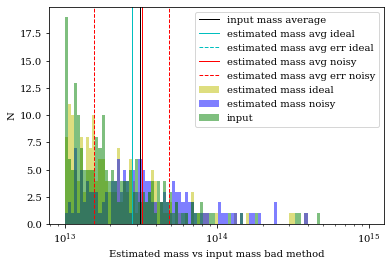

[14125211196469.174, 9575865929515.195, 22136908994303.91, 24747305256923.19, 10463512891841.707, 8125039913363.134, 7781338442844.956, 15133973383215.0, 6018933265539.422, 6679584008793.763, 30097884692950.2, 6462249269334.034, 10574445060399.852, 12762340993872.25, 8685150222182.054, 32665031367726.324, 8543001715889.615, 21314790797714.613, 10344849583075.729, 12700581573159.637, 10925201970764.592, 10651005224381.176, 11282701836738.584, 8930999027140.678, 14219613359623.387, 8356622337998.105, 51818978682172.81, 10596698312450.002, 24501376370882.758, 15115309238866.469, 13971572768714.836, 11603472461812.027, 6559411091353.263, 18373240039897.848, 14459856291806.764, 20409824429952.65, 14922855890778.404, 9460810492795.863, 14225021936931.594, 112221048947588.23, 40516636093879.08, 47620045618748.82, 15194695892012.646, 9499810575762.031, 15975934186541.725, 10977855918126.158, 12196708056054.318, 8760929035261.848, 13372055582518.248, 11239411609252.662, 14594710822820.475, 1980

In [31]:
#input estimated masszdistrib
plt.hist(m_est_ideal_singlez, bins=np.logspace(13,15,100), facecolor='y', alpha=0.5, label="estimated mass ideal")
plt.hist(m_est_noisy_singlez, bins=np.logspace(13,15,100), facecolor='b', alpha=0.5, label="estimated mass noisy")
plt.axvline(cluster_data_mass_avg, color='k', linestyle='solid', linewidth=1 , label="input mass average")
plt.axvline(m_est_ideal_singlez_avg, color='c', linestyle='solid', linewidth=1, label="estimated mass avg ideal")
plt.axvline(m_est_ideal_singlez_avg-m_est_ideal_singlez_avg_err, color='c', linestyle='dashed', linewidth=1, label="estimated mass avg err ideal")
plt.axvline(m_est_ideal_singlez_avg+m_est_ideal_singlez_avg_err, color='c', linestyle='dashed', linewidth=1)
plt.axvline(m_est_noisy_singlez_avg, color='r', linestyle='solid', linewidth=1, label="estimated mass avg noisy")
plt.axvline(m_est_noisy_singlez_avg-m_est_noisy_singlez_avg_err, color='r', linestyle='dashed', linewidth=1, label="estimated mass avg err noisy")
plt.axvline(m_est_noisy_singlez_avg+m_est_noisy_singlez_avg_err, color='r', linestyle='dashed', linewidth=1)
plt.hist(cluster_data[:,0],bins=np.logspace(13,15,100), facecolor='g', alpha=0.5 , label="input")
#plt.errorbar(m_est_ideal_singlez_avg,0, xerr=m_est_ideal_singlez_avg_err, fmt="", color="r")
plt.xlabel('Estimated mass vs input mass bad method')
plt.legend(loc="upper right")
plt.gca().set_xscale("log")
plt.ylabel('N')
plt.show()
print(m_est_err_noisy_singlez)

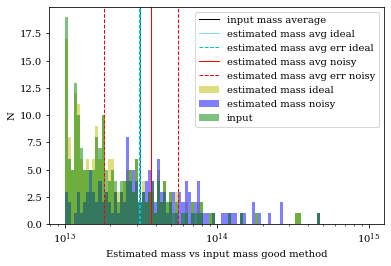

[14125211196469.174, 9575865929515.195, 22136908994303.91, 24747305256923.19, 10463512891841.707, 8125039913363.134, 7781338442844.956, 15133973383215.0, 6018933265539.422, 6679584008793.763, 30097884692950.2, 6462249269334.034, 10574445060399.852, 12762340993872.25, 8685150222182.054, 32665031367726.324, 8543001715889.615, 21314790797714.613, 10344849583075.729, 12700581573159.637, 10925201970764.592, 10651005224381.176, 11282701836738.584, 8930999027140.678, 14219613359623.387, 8356622337998.105, 51818978682172.81, 10596698312450.002, 24501376370882.758, 15115309238866.469, 13971572768714.836, 11603472461812.027, 6559411091353.263, 18373240039897.848, 14459856291806.764, 20409824429952.65, 14922855890778.404, 9460810492795.863, 14225021936931.594, 112221048947588.23, 40516636093879.08, 47620045618748.82, 15194695892012.646, 9499810575762.031, 15975934186541.725, 10977855918126.158, 12196708056054.318, 8760929035261.848, 13372055582518.248, 11239411609252.662, 14594710822820.475, 1980

In [32]:
#input estimated masszdistrib
pyrand = np.random.normal(m_est_ideal_zdistrib
                        ,m_est_err_ideal_zdistrib)
#plt.plot(pyrand)
plt.hist(m_est_ideal_zdistrib, bins=np.logspace(13,15,100),  facecolor='y', alpha=0.5, label="estimated mass ideal")
plt.hist(m_est_noisy_zdistrib, bins=np.logspace(13,15,100),  facecolor='b', alpha=0.5, label="estimated mass noisy")
plt.axvline(cluster_data_mass_avg, color='k', linestyle='solid', linewidth=1 , label="input mass average")
plt.axvline(m_est_ideal_zdistrib_avg, color='c',alpha=0.5, linestyle='solid', linewidth=1, label="estimated mass avg ideal")
plt.axvline(m_est_ideal_zdistrib_avg-m_est_ideal_zdistrib_avg_err, color='c', linestyle='dashed', linewidth=1, label="estimated mass avg err ideal")
plt.axvline(m_est_ideal_zdistrib_avg+m_est_ideal_zdistrib_avg_err, color='c', linestyle='dashed', linewidth=1)
plt.axvline(m_est_noisy_zdistrib_avg, color='r', linestyle='solid', linewidth=1, label="estimated mass avg noisy")
plt.axvline(m_est_noisy_zdistrib_avg-m_est_noisy_zdistrib_avg_err, color='r', linestyle='dashed', linewidth=1, label="estimated mass avg err noisy")
plt.axvline(m_est_noisy_zdistrib_avg+m_est_noisy_zdistrib_avg_err, color='r', linestyle='dashed', linewidth=1)
plt.hist(cluster_data[:,0], bins=np.logspace(13,15,100), facecolor='g', alpha=0.5 , label="input")
#plt.errorbar(m_est_ideal_singlez_avg,0, xerr=m_est_ideal_singlez_avg_err, fmt="", color="r")
plt.xlabel('Estimated mass vs input mass good method')
plt.xscale('log')
plt.legend(loc="upper right")
plt.ylabel('N')
plt.show()
print(m_est_err_noisy_singlez)

In [33]:
'''
import numpy as np
from scipy import stats

pyrand = np.random.normal(m_est_ideal_zdistrib_avg
                        ,np.std(m_est_err_ideal_zdistrib))

print()    
y_data = stats.norm.pdf(m_est_ideal_zdistrib, 0, 1)
plt.plot(m_est_ideal_zdistrib,y_data)

plt.xscale('log')
plt.show()               
'''

"\nimport numpy as np\nfrom scipy import stats\n\npyrand = np.random.normal(m_est_ideal_zdistrib_avg\n                        ,np.std(m_est_err_ideal_zdistrib))\n\nprint()    \ny_data = stats.norm.pdf(m_est_ideal_zdistrib, 0, 1)\nplt.plot(m_est_ideal_zdistrib,y_data)\n\nplt.xscale('log')\nplt.show()               \n"

In [34]:
'''
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np



mean = m_est_noisy_singlez_avg 
std = np.std(m_est_err_noisy_singlez)

x = np.logspace(11, 15, num=100, endpoint=True, base=10.0, dtype=None, axis=0)

y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.grid()

plt.xlim(x_min,x_max)


plt.xlabel('x')
plt.ylabel('Normal Distribution')
plt.xscale('log')
plt.show()

'''

"\nimport matplotlib.pyplot as plt\nimport scipy.stats\nimport numpy as np\n\n\n\nmean = m_est_noisy_singlez_avg \nstd = np.std(m_est_err_noisy_singlez)\n\nx = np.logspace(11, 15, num=100, endpoint=True, base=10.0, dtype=None, axis=0)\n\ny = scipy.stats.norm.pdf(x,mean,std)\n\nplt.plot(x,y, color='coral')\n\nplt.grid()\n\nplt.xlim(x_min,x_max)\n\n\nplt.xlabel('x')\nplt.ylabel('Normal Distribution')\nplt.xscale('log')\nplt.show()\n\n"

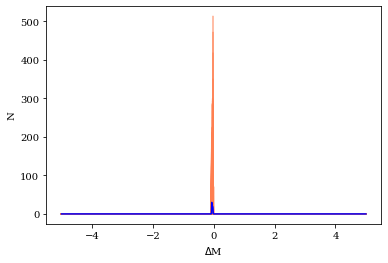

In [64]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_ideal_singlez = np.log10(m_est_ideal_singlez)-np.log10(cluster_data[:,0])
#print(difference)
std_ideal_singlez = (1/np.log(10))*np.array(m_est_err_ideal_singlez)/np.array(m_est_ideal_singlez)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_ideal_singlez = 0

for k in range(num):

    y_ideal_singlez = scipy.stats.norm.pdf(x,difference_ideal_singlez[k],std_ideal_singlez[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_ideal_singlez = ysum_ideal_singlez + y_ideal_singlez
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_ideal_singlez, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_ideal_singlez/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

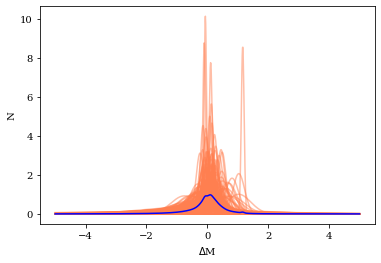

In [97]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_noisy_singlez = np.log10(m_est_noisy_singlez)-np.log10(cluster_data[:,0])
#print(difference)
std_noisy_singlez = (1/np.log(10))*np.array(m_est_err_noisy_singlez)/np.array(m_est_noisy_singlez)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_noisy_singlez = 0

for k in range(num):

    y_noisy_singlez = scipy.stats.norm.pdf(x,difference_noisy_singlez[k],std_noisy_singlez[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_noisy_singlez = ysum_noisy_singlez + y_noisy_singlez
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_noisy_singlez, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_noisy_singlez/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

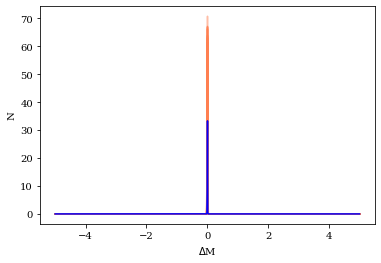

In [66]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_ideal_zdistrib = np.log10(m_est_ideal_zdistrib)-np.log10(cluster_data[:,0])
#print(difference)
std_ideal_zdistrib = (1/np.log(10))*np.array(m_est_err_ideal_zdistrib)/np.array(m_est_ideal_zdistrib)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_ideal_zdistrib = 0

for k in range(num):

    y_ideal_zdistrib = scipy.stats.norm.pdf(x,difference_ideal_zdistrib[k],std_ideal_zdistrib[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_ideal_zdistrib = ysum_ideal_zdistrib + y_ideal_zdistrib
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_ideal_zdistrib, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_ideal_zdistrib/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

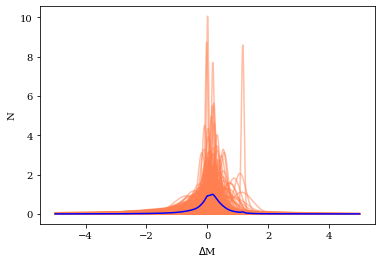

In [84]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_noisy_zdistrib = np.log10(m_est_noisy_zdistrib)-np.log10(cluster_data[:,0])
#print(difference)
std_noisy_zdistrib = (1/np.log(10))*np.array(m_est_err_noisy_zdistrib)/np.array(m_est_noisy_zdistrib)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_noisy_zdistrib = 0

for k in range(num):

    y_noisy_zdistrib = scipy.stats.norm.pdf(x,difference_noisy_zdistrib[k],std_noisy_zdistrib[k])
    ysum_noisy_zdistrib = ysum_noisy_zdistrib + y_noisy_zdistrib
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_noisy_zdistrib, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_noisy_zdistrib/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

In [68]:
'''
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
mean = np.log(m_est_noisy_singlez)/np.log(10)


std = m_est_err_noisy_singlez/np.log(m_est_noisy_singlez)
print(mean)
print(std)
x_min=12
x_max=15
x = np.linspace(x_min, x_max, 1000)
for k in range(num):

    y = scipy.stats.norm.pdf(x,mean[k],std[k])

#plt.plot(x,y, color='coral')

   

    plt.plot(x,y, color='coral')
plt.xlabel('x')
plt.ylabel('Normal Distribution')

plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport scipy.stats\nimport numpy as np\nfrom math import log, exp\nmean = np.log(m_est_noisy_singlez)/np.log(10)\n\n\nstd = m_est_err_noisy_singlez/np.log(m_est_noisy_singlez)\nprint(mean)\nprint(std)\nx_min=12\nx_max=15\nx = np.linspace(x_min, x_max, 1000)\nfor k in range(num):\n\n    y = scipy.stats.norm.pdf(x,mean[k],std[k])\n\n#plt.plot(x,y, color='coral')\n\n   \n\n    plt.plot(x,y, color='coral')\nplt.xlabel('x')\nplt.ylabel('Normal Distribution')\n\nplt.show()\n"

<function matplotlib.pyplot.show(close=None, block=None)>

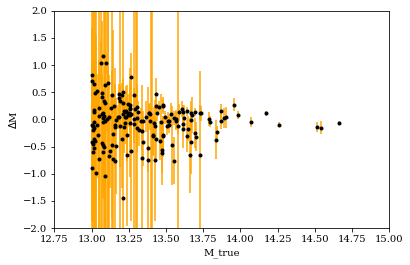

In [45]:
plt.scatter(np.log10(cluster_data[:,0]),difference, alpha = 0.5, s=0.1, marker=',')
plt.xlabel('M_true')
plt.ylabel('$\Delta$M')
plt.axis([12.75,15,-2, 2])
plt.errorbar(np.log10(cluster_data[:,0]), difference, yerr=std, fmt='.', ecolor = 'orange',c='black')
plt.show


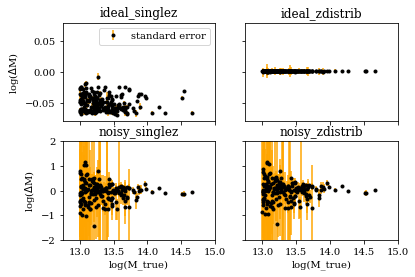

In [160]:
#alle methoden in einem Plot

fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(np.log10(cluster_data[:,0]),difference_ideal_singlez, alpha = 0.5, s=0.1, marker=',')
axs[0, 0].set_title('ideal_singlez')
axs[0, 0].errorbar(np.log10(cluster_data[:,0]), difference_ideal_singlez, yerr=std_ideal_singlez, fmt='.', ecolor = 'orange',c='black',label='standard error')
axs[0, 0].set_xlim([12.75,15])
axs[0, 0].set_ylim([-0.08,0.08])
axs[0, 0].legend(loc="best")

axs[1, 0].scatter(np.log10(cluster_data[:,0]),difference_noisy_singlez, alpha = 0.5, s=0.1, marker=',')
axs[1, 0].set_title('noisy_singlez')
axs[1, 0].errorbar(np.log10(cluster_data[:,0]), difference_noisy_singlez, yerr=std_noisy_singlez, fmt='.', ecolor = 'orange',c='black')
axs[1, 0].set_xlim([12.75,15])
axs[1, 0].set_ylim([-2,2])

axs[0, 1].scatter(np.log10(cluster_data[:,0]),difference_ideal_zdistrib, alpha = 0.5, s=0.1, marker=',')
axs[0, 1].set_title('ideal_zdistrib')
axs[0, 1].errorbar(np.log10(cluster_data[:,0]), difference_ideal_zdistrib, yerr=std_ideal_zdistrib, fmt='.', ecolor = 'orange',c='black')
axs[0, 1].set_xlim([12.75,15])
axs[0, 1].set_ylim([-0.08,0.08])

axs[1, 1].scatter(np.log10(cluster_data[:,0]),difference_noisy_zdistrib, alpha = 0.5, s=0.1, marker=',',label='log10($\Delta$M) for each cluster')
axs[1, 1].set_title('noisy_zdistrib')
axs[1, 1].errorbar(np.log10(cluster_data[:,0]), difference_noisy_zdistrib, yerr=std_noisy_zdistrib, fmt='.', ecolor = 'orange',c='black',label='standard error')
axs[1, 1].set_xlim([12.75,15])
axs[1, 1].set_ylim([-2,2])


for ax in axs.flat:
    ax.set(xlabel='log(M_true)', ylabel='log($\Delta$M)')

 #Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

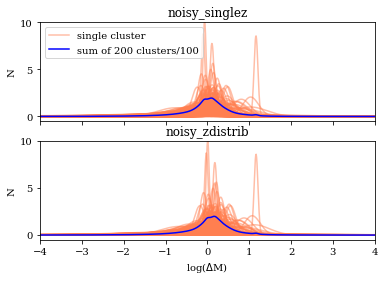

In [154]:

#alle methoden in einem Plot
ysum_ideal_singlez = 0
ysum_noisy_singlez = 0
ysum_ideal_zdistrib = 0
ysum_noisy_zdistrib = 0
fig, axs = plt.subplots(2,1)

for k in range(num):
    y_noisy_singlez = scipy.stats.norm.pdf(x,difference_noisy_singlez[k],std_noisy_singlez[k])
    ysum_noisy_singlez = ysum_noisy_singlez + y_noisy_singlez
    axs[0].plot(x,y_noisy_singlez, color='coral',alpha=0.5)
axs[0].plot(x,y_noisy_singlez, color='coral',alpha=0.5, label='single cluster')
axs[0].plot(x,ysum_noisy_singlez/100, color='blue',label='sum of 200 clusters/100')
axs[0].set_title('noisy_singlez')
axs[0].set_xlim([-4,4])
axs[0].set_ylim([-0.5,10])
axs[0].legend(loc="upper left")

for k in range(num):
    y_noisy_zdistrib = scipy.stats.norm.pdf(x,difference_noisy_zdistrib[k],std_noisy_zdistrib[k])
    ysum_noisy_zdistrib = ysum_noisy_zdistrib + y_noisy_zdistrib
    axs[1].plot(x,y_noisy_zdistrib, color='coral',alpha=0.5)
axs[1].plot(x,y_noisy_zdistrib, color='coral',alpha=0.5,label='single cluster')    
axs[1].plot(x,ysum_noisy_zdistrib/100, color='blue',label='sum of 200 clusters/100')
axs[1].set_title('noisy_zdistrib')
axs[1].set_xlim([-4,4])
axs[1].set_ylim([-0.5,10])
#axs[1].legend(loc="upper left")

for ax in axs.flat:
    ax.set(xlabel='log($\Delta$M)', ylabel='N')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [130]:
sigma=[]
help(clmm.cosmology.cluster_toolkit.AstroPyCosmology.eval_sigma_crit)
for k in range(num):
    sigma  = clmm.cosmology.cluster_toolkit.AstroPyCosmology.eval_sigma_crit(sigma,cluster_data[k][4], cl_ideal[k].galcat['z'])
    
    
    

Help on function eval_sigma_crit in module clmm.cosmology.parent_class:

eval_sigma_crit(self, z_len, z_src)
    Computes the critical surface density
    
    Parameters
    ----------
    z_len : float
        Lens redshift
    z_src : array_like, float
        Background source galaxy redshift(s)
    
    Returns
    -------
    float
        Cosmology-dependent critical surface density in units of :math:`M_\odot\ Mpc^{-2}`



AttributeError: 'list' object has no attribute 'validate_input'

In [126]:
#compute the excess surface density
excess_sigma=[]
for k in range(num):
    excess_sigma=compute_excess_surface_density(r[k],cluster_data[k][0],cluster_data[k][1],cluster_data[k][4],cosmo,delta_mdef=200,halo_profile_model='nfw',massdef='mean')


NameError: name 'compute_excess_surface_density' is not defined